In [1]:
# Aplico diccionario a todas las encuestas, despues NLP a las que tienen texto libre

In [ ]:
Hiperparametros:
    acentos?
    epochs
    optimizaer_len rate
    qty de LSTM
    bidireccional o no
    dimensión del embedding
    lemmatizar si/no
    misspelling si/no
    max words por frase (20-40)
    qty de palabras que va a identificar el modelo. num_wordsmax: (8000)

In [2]:
# Diccionario

In [3]:
import pandas as pd
#Aplico un diccionario de temas inicialmente a todas las encuestas.
df2=pd.read_excel('Encuestas_Temas_Diccionario.xlsx')

In [5]:
#A este grupo, aplicarle el diccionario de la columna 'Diccionario'
df_sin_campo_libre=df2[df2['Campo libre']=='no']

#A este grupo, aplicarle el NLP según lo que se escribió en la Encuesta en el texto libre
df_con_campo_libre=df2[df2['Campo libre']=='si']


In [6]:
dicc=df2.set_index(['Etiquetas de fila'])['Diccionario'].to_dict()
Subtipo='P_Dev. Orden de Servicio/Cupón'
try:
    Cateogria_tema=dicc[Subtipo]
except: 
    Cateogria_tema=Subtipo
    
print(Cateogria_tema)

P_Dev. Orden de Servicio/Cupón


In [7]:
#NLP

# PROCESO


1- Preprocesamiento/Limpieza: lower, numeros,caracteres,tildes,etc.

2- Categorizar label, tokenizar y sequencializar, definir variables

3 - Lemmatization/stemming??

4- Definiciones y análisis

5- Genero modelo


In [290]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nlp #Libreria de huggingface de Datasets
import random

pd.set_option('display.max_colwidth', -1)

<ipython-input-290-02c548883d9b>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [351]:
# SELECCIONO EL DATASET

df=pd.read_excel('Encuestas_FrasesyTemas_muestra_textolibre.xlsx')
df.head()
df=df[~df['category'].isnull()]

C:\Users\Usuario\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [352]:
df=df[df['Origen']!='Muestra, afuera']

In [222]:
# Diccionario_Efecty={'santander':'banco','servicio Bancario':'banco',
#                     'agua':'servicio','gas':'servicio','datafono':'servicio','wester union','recaudo':'servicio'
#                     'sistema':'sieweb','plataforma':'sieweb','sieweblive':'sieweb',
#                    'corresponsal bancario':'pap',
#                    'tope':'topes' 
#                     subsidios: FAMILIAS EN ACCION, DAVIPLATA, DEVOLUCION DEL IVA, FIDUAGRARIA, INGRESO SOLIDARIO, JOVENES ACCION
#                    Otras plataformas:  bancolombia y davivienda
#                     wiki,wikipedia, convenios,
#                    "revisa la wiki", superhero, baloto, su red, daviplta, servientrega, pasarela de pago
#                    dimonex es una empresa asociados a ellos. podría reducirlo a Efecty
# #                    }

# Preprocesamientorename

In [293]:
category=df.category.unique()
category

class_to_index=dict((c,i) for i,c in enumerate(category)) #cambiar classes por category por ahi
index_to_class=dict((v,k) for k,v in class_to_index.items())

df['label']=df['category'].replace(class_to_index)
df['comentario']=df['comentario inic']

In [294]:
#Limpieza de formato
import re
df['comentario']=df['comentario'].apply(lambda x: str(x).lower())
df['comentario']=df['comentario'].apply(lambda x: re.sub('á','a',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub('é','e',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub('í','i',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub('ó','o',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub('ú','u',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub("""http.*?\s""",'',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub("""[.,]{0,3}|@|[0-9]|\n|[¡!@#$:)(;¿?&\-'_%]""",'',str(x)))

In [295]:
stop_words=[]
stop_words = (pd.read_excel('Encuestas_TemasyFrases_stop_words_sin_tilde1.xlsx')) 
stop_words=list(stop_words['stopwords'])


In [296]:
for f in stop_words:
    df['comentario']=df['comentario'].apply(lambda x: re.sub(r'\s'+f+'\s',' ',str(x)))
    df['comentario']=df['comentario'].apply(lambda x: re.sub(r'^'+f+'\s',' ',str(x)))

# Genero definiciones

In [297]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.25, #Es el 15% de la muestra es para validación (diferente a test! val sirve para reentrenar automaticamente)
    random_state=17, #Se asigna un seed. para que sean siempre el mismo random
    stratify=df.label.values #Aca lo que hace, es que asigna las diviciones por los labels values
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=17,stratify=y_train) # 0.25 x 0.8 = 0.2


In [298]:
#Cantidad de categorias definidas
qty_label=len(df.label.unique())


# Al Dataframe le agrego la marca a cada index si es val, train o test
df['data_type']='not_set'

df.loc[X_train,'data_type']='train'
df.loc[X_val,'data_type']='val'
df.loc[X_test,'data_type']='test'

df.groupby(['data_type','category']).count()

Origen  Unnamed: 2  \
data_type category                                              
test      Capacitación y atención de PAPs  21      0            
          Convenios y franquicias          36      0            
          Marketing/publicidad             12      0            
          Otros                            16      0            
          Satisfacción                     19      0            
          Sieweb                           41      0            
          Soporte a PAPs                   42      0            
          Topes                            22      0            
          sin comentarios                  43      0            
train     Capacitación y atención de PAPs  49      0            
          Convenios y franquicias          80      0            
          Marketing/publicidad             28      0            
          Otros                            36      0            
          Satisfacción                     42      0            
          Sieweb                           90      0            
          Soporte a PAPs                   95      0            
          Topes                            49      0            
          sin comentarios                  95      0            
val       Capacitación y atención de PAPs  16      0            
          Convenios y franquicias          27      0            
          Marketing/publicidad             9       0            
          Otros                            12      0            
          Satisfacción                     14      0            
          Sieweb                           31      0            
          Soporte a PAPs                   32      0            
          Topes                            16      0            
          sin comentarios                  32      0            

                                           comentario inic  label  comentario  
data_type category                                                             
test      Capacitación y atención de PAPs  21               21     21          
          Convenios y franquicias          36               36     36          
          Marketing/publicidad             12               12     12          
          Otros                            16               16     16          
          Satisfacción                     19               19     19          
          Sieweb                           41               41     41          
          Soporte a PAPs                   42               42     42          
          Topes                            22               22     22          
          sin comentarios                  42               43     43          
train     Capacitación y atención de PAPs  49               49     49          
          Convenios y franquicias          80               80     80          
          Marketing/publicidad             28               28     28          
          Otros                            36               36     36          
          Satisfacción                     42               42     42          
          Sieweb                           90               90     90          
          Soporte a PAPs                   95               95     95          
          Topes                            49               49     49          
          sin comentarios                  90               95     95          
val       Capacitación y atención de PAPs  16               16     16          
          Convenios y franquicias          27               27     27          
          Marketing/publicidad             9                9      9           
          Otros                            12               12     12          
          Satisfacción                     14               14     14          
          Sieweb                           31               31     31          
          Soporte a PAPs                   32               32     32        

In [299]:
#Definiciones a futuro útiles

train=df.data_type=='train'
val=df.data_type=='val'
test=df.data_type=='test'

all_comentarios=np.array(df.comentario)
label=df.label.unique()

In [300]:
#MISPELL

from autocorrect import Speller
spell = Speller(lang='es')

# diccionario propio de efecty: efecty, siwewb, TUCUENTA, Portalvirtual,trilla
# spell('prevalidar')

#LEMMATIZACION
import spacy
nlp = spacy.load('es_core_news_lg')

In [301]:
#Lemmatizar

for i in range(0,len(df['comentario'])):
    try:
        doc = nlp(str(df['comentario'][i]))
        aux2=[]
        for j in range(0,len(doc)):
            aux2.append(spell(str(doc[j])))
        df['comentario'][i]=re.sub("""'|,|[][]""",'',str(aux2))
        doc2 = nlp(df['comentario'][i])
        for k in range(0,len(doc2)):
            aux = [tok.lemma_.lower() for tok in doc]
            df['comentario'][i]=re.sub("""'|,|[][]""",'',str(aux))
    except:
        pass

<ipython-input-301-ec1ce21fa373>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comentario'][i]=re.sub("""'|,|[][]""",'',str(aux2))
<ipython-input-301-ec1ce21fa373>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comentario'][i]=re.sub("""'|,|[][]""",'',str(aux))


# Tokenizar

In [302]:
#Entender cuantas palabras tengo que se repiten 1 vez,2 veces y más de 3 veces

In [303]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [304]:
comentario_train=df[df.data_type=='train']['comentario']

num_wordsmax=8000
tokenizer=Tokenizer(num_words=num_wordsmax,oov_token='<UNK>') #Si la palabra no esta entre las 10.000 mas usadas, se guarda como <UNK> y su propio seq
tokenizer.fit_on_texts(comentario_train)

In [305]:
# aplicar Diccionario_Efecty a todas las palabras

In [306]:
#ANALIZO CUANTAS VECES SE REPITEN LAS PALABRAS, DISTRIBUCIÓN DE LAS PALABRAS


palaras=pd.DataFrame(tokenizer.word_docs.items(), columns=['palabras', 'frecuencia']).sort_values(by='frecuencia',ascending=False)
frecuencia_palabras=palaras.groupby('frecuencia').count().head(15)
cantidad_de_palabras=palaras['palabras'].count()

print(int(cantidad_de_palabras))
print(frecuencia_palabras)
print(palaras.head(15))

1815
            palabras
frecuencia          
1           1035    
2           260     
3           137     
4           94      
5           53      
6           32      
7           20      
8           21      
9           25      
10          17      
11          11      
12          12      
13          11      
14          9       
15          6       
     palabras  frecuencia
8    mas       148       
108  punto     97        
50   servicio  92        
105  hacer     67        
197  poder     65        
35   cliente   64        
140  cuando    63        
762  ninguno   57        
32   momento   56        
176  mejorar   53        
44   efecty    50        
11   él        49        
182  convenio  49        
9    dar       44        
219  sistema   42        


In [307]:
#Encontrar un token o una palabra
print(tokenizer.sequences_to_texts([[500]]))
print(tokenizer.texts_to_sequences(['thanks']))

['servidor']
[[1]]


- Padding. Determinar la cantidad de palabras por frase
- Sequencial. Pasar de palabra a numero

In [308]:
lengh=[len(t.split(' ')) for t in all_comentarios]

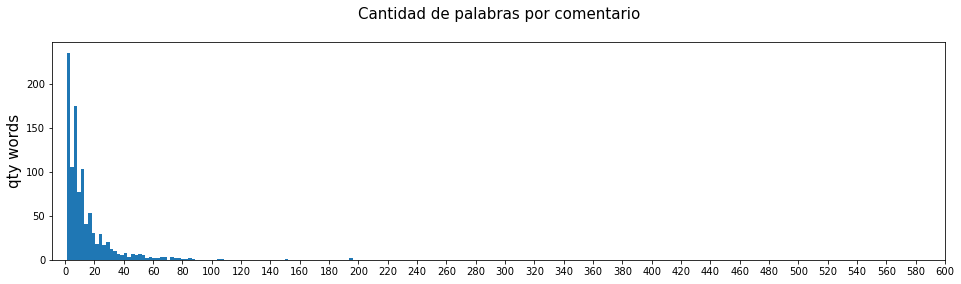

In [309]:
plt.figure(figsize=[16,4])
plt.hist(lengh, bins=80)
plt.ylabel('qty words',fontsize=15)
plt.title('Cantidad de palabras por comentario\n',fontsize=15)
cont=np.linspace(0, 600,31)
plt.xticks(ticks=cont)
plt.show()

In [310]:
maxlen=20 #Lo defino yo en base al ultimo grafico
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [311]:
#Ejemplo de un comentario tokenizado
df['com_tokenizado']=0
df['com_padded']=0
token_all=tokenizer.texts_to_sequences(all_comentarios)
# for i in range(0,len(df.index)): #OPTIMIZARLO CON INDEX? TARDA MUCHO
#     token=tokenizer.texts_to_sequences(all_comentarios[i])
#     df['com_tokenizado'][i]=str(token)
#     df['com_padded'][i]=str(pad_sequences(token_all,padding='post',maxlen=maxlen)[0])


# PREPARING LABELS

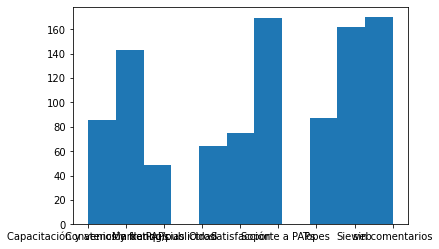

In [312]:
plt.hist(df.category,bins=11)
plt.show()

# Genero el modelo

Hyperparametros:
- dimension de embedding
- cantidad de redes
- canitdad de neuronas por redes
- loss/optimizer
- learning rate
- epoch
    

In [246]:
# Se puede optar por embedding o One Hot Encoding (que cada palabra sea un vector de 0s con 1 uno en la unique word)
# Embedding sirve para cualquier idioma! porque trabaja con tokens y sus relaciones en los inputs, no con texto

In [330]:
# Embedding: OBJETIVO, ES QUE LA RED LSTM CONSIDERE PALABRAS SEMEJANTES, COMO TALES
#lo que hace es generar 1 vector de 0s con solo 1 uno para cada unique word, y el output es el mismo vector, pero algunos 0s cambian de valor!! 
# En el entrenamiento, lo que se hace es que las mismas palabras tengan pesos semejantes segun contexto! Se entrena de forma supervisada, enseñandole que el output, es la frase.

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=10000,output_dim=15,input_length=maxlen),
    #10.000 unique words. 16 output interno. Cada palabra va a estar representado con un vector de 16 dimensiones
    #output_dim (hyperparameter):
        #The larger vocabulary you have you want better representation of it - make the layer larger.
        #Si son pocas palabras, y la dim de output es muy grande, seguro hay overfitting.
        #Si el input es muy variado, quiero comprimir mas (el)
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)), #Bidirecional significa que el contexto puede provenir de la derecha o izq del texto. Son 2 LSTM pero en los 2 ordenes!!
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(qty_label,activation='softmax') #Output, 6 dimensiones (triste, happy, etc.)
])

model.compile(
    loss='sparse_categorical_crossentropy',  #Se define el error buscado. 'sparse_categorical_crossentropy' se usa para problemas de clasificacion
    optimizer='adam', #Se encarga de ajustar la velocidad, tiempos, para llegar al punto más optimo, y tener la mayor accuracy (precisión). Ojo con overfitting aca
    metrics='accuracy'
) #loss y optimazer, usan el concepto de Gradient Descent (GD), que es cuan rapido quiero llegar al optimazer

model.optimizer.learning_rate=0.001


#LEARNING RATE: La velocidad en la que quiero que el modelo aprenda. Comparo: error minimo vs Epoch. (creo que se modifica en el optimzaer)
# Si voy muy lento, nunca voy a llegar al error mínimo y hay riesgo de overfitting.
# Si voy muy rapido, los cambios de estado serán tan grandes que nunca voy a llegar al error mínimo. riesgo underfitting

# POSSIBLE LOSSES: is used to find error or deviation in the learning process.
# Es la diferencia entre lo predicto y lo real en cada train. predijo 0,7 y era 0. tiene que ir modificando los 
# pesos de las neuronas para que la próxima vez esté mas cerca de 0

    # mean_squared_error (regression_loss_funcion. va aintentar disminuir el error de la distancia entre predicción-real)
    # mean_absolute_error (regression_loss_funcion)
    # mean_absolute_percentage_error (regression_loss_funcion.
    # mean_squared_logarithmic_error (regression_loss_funcion.)
    # squared_hinge
    # hinge
    # categorical_hinge
    # logcosh
    # huber_loss
    # categorical_crossentropy
    # sparse_categorical_crossentropy: es lo mas comun para clasificacion de numeros enteros categricos
    # binary_crossentropy
    # kullback_leibler_divergence
    # poisson
    # cosine_proximity
    # is_categorical_crossentropy
    
    
# POSSIBLE OPTIMIZER:important process which optimize the input weights by comparing the prediction
# and the loss function
    # SGD 
    # RMSprop 
    # Adagrad 
    # Adadelta 
    # Adam. Es la mas comun
    # Adamax 
    # Nadam 


# POSSIBLE METRICS: is used to evaluate the performance of your model. It is similar to loss function,
# but not used in training process
    # accuracy
    # binary_accuracy
    # categorical_accuracy
    # sparse_categorical_accuracy
    # top_k_categorical_accuracy
    # sparse_top_k_categorical_accuracy
    # cosine_proximity
    # clone_metric

In [331]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 15)            150000    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 20, 40)            5760      
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 40)                9760      
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 369       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


In [332]:
def get_sequences(tokenizer,comentario):
    sequences=tokenizer.texts_to_sequences(comentario)
    padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen) #Rellena con 0s para que todos los tweets tengan mismo largo
    return padded

In [333]:
label_train=df[df.data_type=='train']['label']
label_val=df[df.data_type=='val']['label']


sequences_train=tokenizer.texts_to_sequences(comentario_train)
padded_train_seq=pad_sequences(sequences_train,truncating='post',padding='post',maxlen=maxlen)

comentario_val=df[df.data_type=='val']['comentario']
sequences_val=tokenizer.texts_to_sequences(comentario_val)
padded_val_seq=pad_sequences(sequences_val,truncating='post',padding='post',maxlen=maxlen)

In [335]:
# model.fit(X, y, epochs = , batch_size = , validation_data = (x_val, y_val))
h=model.fit(padded_train_seq,np.array(label_train),validation_data=(padded_val_seq,np.array(list(label_val))),
    epochs=8)
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)]) #Si al segundo epoch el modelo no ve mejoras en accuracy, frena

Epoch 1/8
18/18 [==============================] - 0s 20ms/step - loss: 1.6815 - accuracy: 0.3493 - val_loss: 1.6992 - val_accuracy: 0.3386
Epoch 2/8
18/18 [==============================] - 0s 17ms/step - loss: 1.6503 - accuracy: 0.3670 - val_loss: 1.6806 - val_accuracy: 0.3492
Epoch 3/8
18/18 [==============================] - 0s 18ms/step - loss: 1.6227 - accuracy: 0.3670 - val_loss: 1.6673 - val_accuracy: 0.3492
Epoch 4/8
18/18 [==============================] - 0s 18ms/step - loss: 1.5696 - accuracy: 0.3812 - val_loss: 1.6542 - val_accuracy: 0.3280
Epoch 5/8
18/18 [==============================] - 0s 18ms/step - loss: 1.4875 - accuracy: 0.4025 - val_loss: 1.5840 - val_accuracy: 0.3439
Epoch 6/8
18/18 [==============================] - 0s 18ms/step - loss: 1.3675 - accuracy: 0.4255 - val_loss: 1.5453 - val_accuracy: 0.3651
Epoch 7/8
18/18 [==============================] - 0s 18ms/step - loss: 1.2419 - accuracy: 0.5106 - val_loss: 1.4916 - val_accuracy: 0.4074
Epoch 8/8
18/18 [===

In [336]:

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


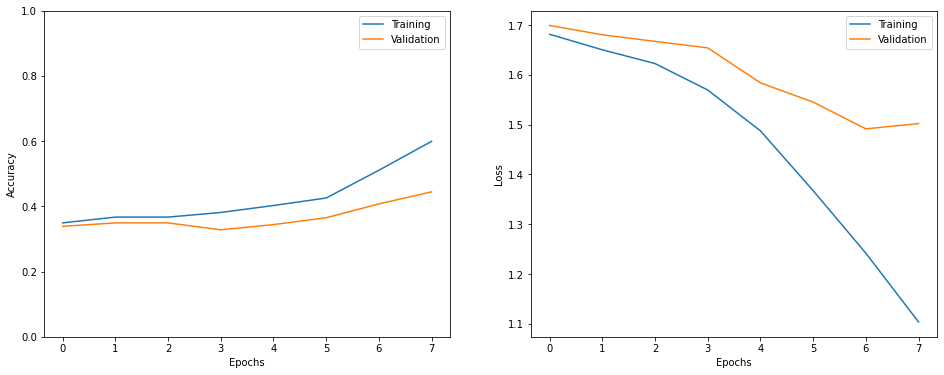

In [337]:
show_history(h)

#Cuando se el train mejora (cae)el loss, pero el loss validation no, sino que sube, eso es un claro Overfitting. 
# Empieza a replicar a la perfección el train

TESTEO CON OTRA MUESTRA REAL

In [338]:
comentario_test=df[df.data_type=='test']['comentario']
sequences_test=tokenizer.texts_to_sequences(comentario_test)
padded_test_seq=pad_sequences(sequences_test,truncating='post',padding='post',maxlen=maxlen)

In [339]:
_=model.evaluate(np.array(padded_test_seq),np.array(y_test))

8/8 [==============================] - 1s 5ms/step - loss: 3.3870 - accuracy: 0.1508


In [340]:
df_test=df[df.data_type=='test'].reset_index()

In [356]:
#Pruebas de testeo sobre comentarios random

rand=random.randint(0,len(df_test)-1) #genero numero random

p=model.predict(np.expand_dims(padded_test_seq[rand],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')] #lo paso a comentario, no numero

print('Sentence:"{}"\nCategory:          "{}"\nPredicted Category "{}"\n\n'.format(
    np.array(df_test['comentario inic'])[rand],
    (df_test['category'][rand]),
    pred_class))


#PARA 2 CATEGROIAS
# print('Ponderación de los labels sobre la frase:\n{} {} \n{} {}'.format(
#     category[0],[round(p[0],2)],
#     category[1],[round(p[1],2)]))

#PARA 3 CATEGROIAS
print('Ponderación de los labels sobre la frase:\n{} {} \n{} {} \n{} {}\n{} {}\n{} {}\n{} {}\n{} {}\n{} {}'.format(
    category[0],[round(p[0],2)],
    category[1],[round(p[1],2)],
    category[2],[round(p[2],2)],
    category[3],[round(p[3],2)],
    category[4],[round(p[4],2)],
    category[5],[round(p[5],2)],
    category[6],[round(p[6],2)],
    category[7],[round(p[7],2)],


))

Sentence:"Seria muy útil el aumento del tope, ya que hay momentos en los que realizo desabastecimiento de dinero y al ratito ya esta lleno . Gracias"
Category:          "Topes"
Predicted Category "Soporte a PAPs"


Ponderación de los labels sobre la frase:
Capacitación y atención de PAPs [0.13] 
Convenios y franquicias  [0.15] 
Marketing/publicidad [0.08]
Otros [0.17]
Satisfacción [0.02]
Soporte a PAPs [0.22]
Topes [0.18]
Sieweb [0.04]


In [349]:
#Predicción de todos los comentarios test
preds=np.argmax(model.predict(padded_test_seq), axis=-1)
preds

df_test['label_predict']=preds
df_test['category_predict']=df_test['label_predict'].replace(index_to_class)

In [350]:
# Vizualizar predicciones
pd.DataFrame(df_test.groupby(['category','category_predict'])['index'].count())

index
category                        category_predict               
Capacitación y atención de PAPs Convenios y franquicias   1    
                                Otros                     1    
                                Soporte a PAPs            10   
                                Topes                     9    
Convenios y franquicias         Convenios y franquicias   8    
                                Sieweb                    13   
                                Soporte a PAPs            13   
                                Topes                     2    
Marketing/publicidad            Convenios y franquicias   1    
                                Soporte a PAPs            6    
                                Topes                     5    
Otros                           Convenios y franquicias   5    
                                Sieweb                    3    
                                Soporte a PAPs            7    
                                sin comentarios           1    
Satisfacción                    Convenios y franquicias   2    
                                Sieweb                    6    
                                Soporte a PAPs            1    
                                sin comentarios           10   
Sieweb                          Convenios y franquicias   3    
                                Sieweb                    24   
                                Soporte a PAPs            9    
                                sin comentarios           5    
Soporte a PAPs                  Convenios y franquicias   8    
                                Sieweb                    4    
                                Soporte a PAPs            28   
                                Topes                     2    
Topes                           Convenios y franquicias   2    
                                Otros                     1    
                                Soporte a PAPs            14   
                                Topes                     5    
sin comentarios                 Sieweb                    3    
                                Soporte a PAPs            1    
                                sin comentarios           39

In [194]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.clf() # Start over
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
cm = confusion_matrix(df_test['category'],df_test['category_predict'])


#CUANDO HAY SOLO 2 CATEGORIAS
# TP=cm[0][0]
# FN=cm[0][1]
# FP=cm[1][0]
# TN=cm[1][1]
# Sens=TP/(TP+FN) #Sensibilidad 
# UnomSp=FP/(FP+TN) #(1-Specify)
# Prec= TP/(TP+FP) # #Precisión
# # Lo mas eficiente es sensibilidad=1, 1-Sepcify=0
# # TP  FN  
# # FP  TN

#CUANDO HAY 3 CATEGORIAS
TP1=cm[0][0]
FN1=cm[0][1]+cm[0][2]
FN1bis=cm[1][2]+cm[2][1]
FP1=cm[1][0]+cm[2][0]
TN1=cm[1][1]+cm[2][2]
Sens=TP1/(TP1+FN1) #Sensibilidad 
UnomSp=FP1/(FP1+TN1+FN1bis) #(1-Specify)
Prec= TP1/(TP1+FP1) # #Precisión
# Lo mas eficiente es sensibilidad=1, 1-Sepcify=0
# TP  FN  
# FP  TN

<Figure size 432x288 with 0 Axes>

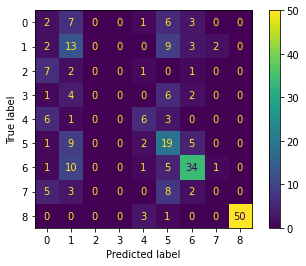

Resultados de Capacitación y atención de PAPs:
De los 9 comentarios test reales "Capacitación y atención de PAPs", el 22.0% fueron correctamente predictos como Capacitación y atención de PAPs (Sensibilidad)
De los 24 comentarios test reales "no Capacitación y atención de PAPs", el 38% fueron erroneamente predictos como Capacitación y atención de PAPs (1-Specify)
De los 11 comentarios test predictos como "Capacitación y atención de PAPs", el 18% fueron correctamente predictos como Capacitación y atención de PAPs (Precisión/Accuracy)


In [195]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 
plt.show()
print(f'Resultados de {category[0]}:')
print(f'De los {TP1+FN1} comentarios test reales "{category[0]}", el {round(Sens,2)*100}% fueron correctamente predictos como {category[0]} (Sensibilidad)')
print(f'De los {TN1+FP1+FN1bis} comentarios test reales "no {category[0]}", el {round(UnomSp*100)}% fueron erroneamente predictos como {category[0]} (1-Specify)') 
print(f'De los {TP1+FP1} comentarios test predictos como "{category[0]}", el {round(Prec*100)}% fueron correctamente predictos como {category[0]} (Precisión/Accuracy)') 

In [197]:
class_to_index 
# sieweb te lo confunde con topes
#Satisfacción con topes y capacitación
#Capacitación con topes

{'Capacitación y atención de PAPs': 0,
 'Convenios y franquicias ': 1,
 'Marketing/publicidad': 2,
 'Otros': 3,
 'Satisfacción': 4,
 'Soporte a PAPs': 5,
 'Topes': 6,
 'Sieweb': 7,
 'sin comentarios': 8}

In [196]:
#GUARDAR EL MODELO! y como volverlo a usar

# from keras.models import load_model

# model.save('modelo_NLP_v1.h5')  # creates a HDF5 file 
# del model  # deletes the existing model


# model = load_model('modelo_NLP_v1.h5') #Carga el modelo guardado para usarlo


In [ ]:
# #Guardar tokenizer!
# import pickle

# # saving
# with open('tokenizer.model_v3', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# import pickle
# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)